# Machine learning algorithms and applications on real world data

In this notebook, we will go through a selection of common supervised ML models used for classification. You will also learn how a typical data scientist might go about to do machine learning on real world datasets. As you'll see, most of the time is actually not spent doing machine learning, but rather in preparing, formatting, cleaning and understanding the data. 

This notebook is in part based on [this](https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_anova_svm.html#sphx-glr-auto-examples-02-decoding-plot-haxby-anova-svm-py) and [this](https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_different_estimators.html#sphx-glr-auto-examples-02-decoding-plot-haxby-different-estimators-py) tutorial from `nilearn`.

As usual we start by importing the required libraries. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

#### Key points from the previous notebook:
- It is ideal to explore and visualize the data prior to doing actual machine learning.
- A model must be instantiated, trained using `.fit` and used to predict using `.predict`.
- You must train your model and test it on separate data. `train_test_split` is a function used for this purpose.
- Metrics for evaluation exist, like accuracy, sensitivity and specificity. More nuances method like the confusion matrix and AUC (not covered yet) are also very useful. `classification_report` gives a neat summary.


Previous notebook we only used SVMs, now we will try a few other models too. Again we need a toy dataset for illustration purposes.

We will cover the algorithms:
- K Nearest neighbors (KNN)
- Naive Bayes
- Decision trees and random forrest
- XGBOOST
- multilayer perceptron

In [2]:
brca = datasets.load_breast_cancer()
print(brca.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [3]:
X = brca.data
y = brca.target

In [4]:
df = pd.DataFrame(X, columns=brca.feature_names)
df.loc[:,'class'] = brca.target_names[y]

In [5]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [6]:
df.groupby('class').size()

class
benign       357
malignant    212
dtype: int64

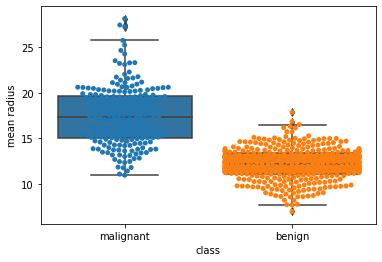

In [7]:
ax = sns.boxplot(x='class', y='mean radius', data=df)
ax = sns.swarmplot(x='class', y='mean radius', data=df)

#### Exercise. Select only the two first features of X (so we can make easy visualizations), in a variable `X2`.

In [8]:
# %load solutions/ex2_1.py
X2 = X[:,:2]

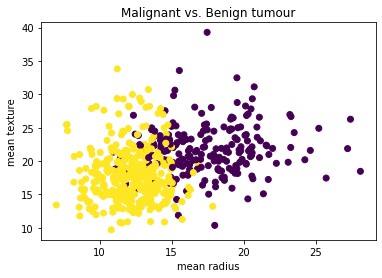

In [9]:
def scatter(X,y, *args):
    if not args:
        i,j=0,1
    else: i,j = args
    plt.scatter(X[:,i], X[:,j], c=y)
    plt.title('Malignant vs. Benign tumour')
    plt.xlabel(brca.feature_names[i])
    plt.ylabel(brca.feature_names[j])
    
scatter(X2,y)

From this figure alone we can expect that we can classify with a high accuracy

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=0)
# random_state ensures the code is reproducible

# K-Nearest neighbors


Consider you have gathered a bunch of blood samples from a two subtypes of diabetics C1 and C2. Each sample contains the concentrations of various serum proteins, and will be used to . Now imagine you had been uncareful and lost which class some sample s belonged to. Before your boss finds out your mistake, how can you best retrieve the correct class label? (Note: this example is purely theoretical).

We proceed by using the general framework of viewing features as numbers along a dimension in hyperspace. For the sake of simplicity, let's only consider two features. Color the healthy samples red and the sick samples blue. How would you decide the correct class of the unkown sample s? Plotting s with the other points should provide a clue.

<img src="assets/knn_example.png" style="width:30%" />

Making a scatter plot provides a strong clue: the unknown point is closer to the red points, so it is reasonable to assume it also should be red. Framed more precisely we can count the k closest neighbors of s, then we let the majority vote decide the true label of s. For instance, looking at the single closest neighbor of s, we would decide upon s belonging to the red group. If we count the 3 nearest neighbors, 2 of them are red. Counting the 5 nearest yields 3 red and 2 blue. In any case, the prediction is the same. But we aren't always so lucky. Here we have alluded to a problem you are guaranteed to face: how many neighbors should you choose? There is not really an optimal value for k, but in general a smaller is more likely to overfit, while a too large value is likely to underfit.

<img src="assets/knn_example_2.png" style="width:30%"/>


In [39]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5) # define the model and specify parameters

In [40]:
clf.fit(X_train, y_train) # train the model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Just like that the model is trained, in two lines of code. Now you are left with a trained algorithm `clf`, which you can use to predict the group belonging of new samples.  

#### Exercise. Test your models performance on the test set by calling the `clf.score` method. Now what happens when you test it on the training set? Why are the two different?

In [41]:
## Your answer here
test_score = clf.score(X_test, y_test)
train_score = clf.score(X_train, y_train)
print(f"test score: {test_score} \ntrain score: {train_score}")

# notice that the train score is higher. This is because the test set is hitherto unseen, and thus more "difficult" to get right.

test score: 0.8421052631578947 
train score: 0.9164835164835164


We can use the comprehensive `classification_report`

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test), target_names=brca.target_names))

              precision    recall  f1-score   support

   malignant       0.84      0.77      0.80        47
      benign       0.85      0.90      0.87        67

    accuracy                           0.84       114
   macro avg       0.84      0.83      0.83       114
weighted avg       0.84      0.84      0.84       114



### Visualize prediction

In [43]:
# helper function, don't worry about the code
def plot_decision_boundary(clf, X, y):
    """
    X : input data. Must have 2 features.
    y : input labels
    clf : the sklearn classifier
    
    """
    h = .05 
    # Define some custom colors
    cmap_light = ListedColormap(['orange', 'pink', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'red', 'darkblue'])
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

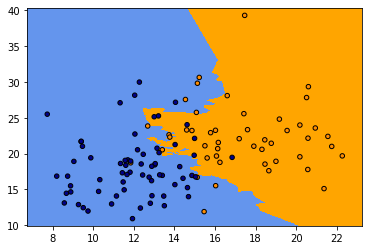

In [44]:
plot_decision_boundary(clf, X_test, y_test)

The background color refers to the prediction space, and the points are colored by the actual class.

So far we have excluded 2 out of 4 features in the dataset. 
#### Exercise. Retrain the algorithm on the full data, and find its score.

In [45]:
#answer
X_full = brca.data
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=0)
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
train_score = clf.score(X_train, y_train)
print(f"test score: {test_score} \ntrain score: {train_score}")

test score: 0.9385964912280702 
train score: 0.9494505494505494


In [47]:
from sklearn.metrics import confusion_matrix

# convenience function
def plot_cm(y, preds):
    cm = confusion_matrix(y, preds)
    plt.imshow(cm, cmap='Reds')
    m = cm.shape[0]
    plt.xticks(range(m))
    plt.yticks(range(m))
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    for i in range(m):
        for j in range(m):
            plt.text(i,j, s=cm[i,j], fontsize=20)
    plt.show()
            

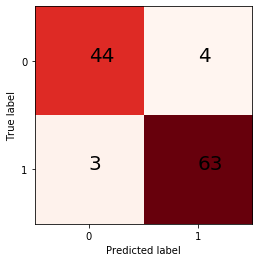

In [50]:
plot_cm(y_test, clf.predict(X_test))

**Ex.XX. Explore the train and test score as you let n_neighbors vary. Can you achieve a perfect score on the test set?**

In [ ]:
# your code here

## Feature scaling

So far we have done minimal preprocessing. With few exceptions, you should always do some basic preprocessing, like standardizing each input feature to zero mean and unit variance. In fact, you should **never** do KNN without standardizing the input first. `sklearn` has a great functionality, and offers a vast number of options for preproccesing in the `preprocessing` sub module.

In addition to the `fit` method, many `sklearn` objects have a `transform` method, which lets you transform your dataset. In this case, the transform yields the dataset post normalization. 

<img src="assets/knn_unnormalized.png" style="width:40%"/>

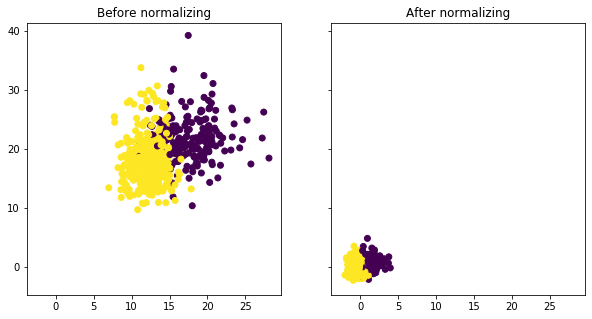

In [191]:
## your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler.fit(X_train) # fit only the training set
X_scaled = scaler.transform(X)

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True) # make two plots on the same row
ax[0].scatter(X[:,0], X[:,1], c=y)
ax[0].set_title('Before normalizing') # set the title of the first subplot
ax[1].scatter(X_scaled[:,0], X_scaled[:,1], c=y) 
ax[1].set_title('After normalizing') # set the title of the second subplot
plt.show()

#### Exercise. Standardize the data before. Hint: you have to fit the scaler to the training set (not the whole dataset), and then transform `X_test` and `X_train` later.

How does it perform compared to before?

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X_full = brca.data

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=0)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
train_score = clf.score(X_train, y_train)
print(f"test score: {test_score} \ntrain score: {train_score}")

test score: 0.956140350877193 
train score: 0.978021978021978


Many datasets are very skewed in this regard, so you should get used to scaling prior to doing KNN. The same holds true before doing PCA and SVM and neural networks, but not decision trees. 

This process was slightly verbose however, and we can compress it. Here is a better method:

### Pipelines

When using multiple transformers in a single model, you can use a Pipeline, which lets you chain all steps into a single algorithm, as in the following example.

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=0)
clf = neighbors.KNeighborsClassifier(n_neighbors=7)
scaler = StandardScaler()

pipe = make_pipeline(scaler, clf)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)

In [194]:
test_score = pipe.score(X_test, y_test)
train_score = pipe.score(X_train, y_train)
print(f"test score: {test_score} \ntrain score: {train_score}")

test score: 0.956140350877193 
train score: 0.9758241758241758


### How the choice of K affects the result
An interesting way to visualize the classifier is to look at its decision boundary.

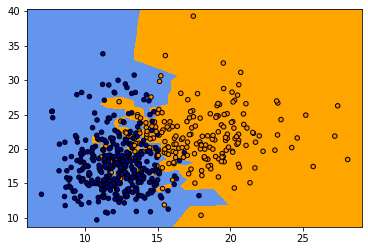

In [196]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=0)
clf.fit(X_train, y_train)
    
plot_decision_boundary(clf, X2, y)
plt.show()

In KNN, the prediction depends on the number of neighbors. **Ex 1: Edit the code below to plot the decision boundary using 1, 7 and 15 neighbors. Explain what you observe**. Hint: write a loop.

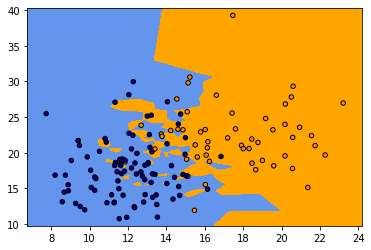

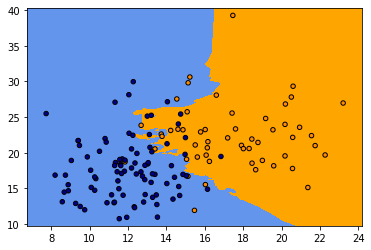

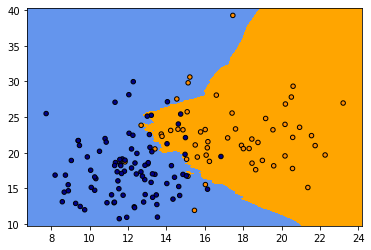

In [197]:
# Your code here

for k in [1, 7, 15]:
    clf = neighbors.KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    plot_decision_boundary(clf, X_test, y_test)
plt.show()

# The decision boundary is more fine-grained for small Ks.

#### Drawbacks to KNN
You will have noticed the above loop took a very long time. KNN in general is not a particularly fast algorithm for large datasets. The training phase is almost instantaneous (just storing the training data). Prediction however requires each datapoint in the test set to be compared to a bunch of points. Especially in high dimensions (many features) this becomes especially slow. Notice that we ran it for just 2 features (`X2`).
Therefore KNN is recommended to be used only for a small number of features. Doing preprocessing first prior to KNN (like feature selection) is not a bad idea.

# Naive Bayes classifier

Naive Bayes classifier is based on the (naive) assumption that features are not correlated. From that, it is simply an application of the Bayes rule: 


---


The benefit of NB is the great speed of computation, and comparatively good classification performance. Such simple models can often perform especially well in complex problems and small datasets.

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_curve, auc, plot_roc_curve

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [19]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.9298245614035088

In [21]:
preds = model.predict(X_test)

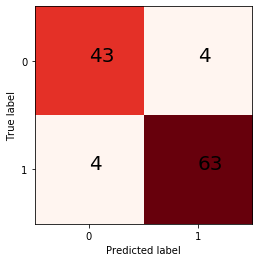

In [36]:
plot_cm(y_test, preds)

## ROC curves

Yet another way of evaluation models is the area under the ROC curve. Here we record the model's *true positive rate* and *false positive rate* under a variation of classification thresholds, and plot them against eachother. This area (AUC) is a particularly good summary statistic, very useful when classes are imbalanced.

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, preds)

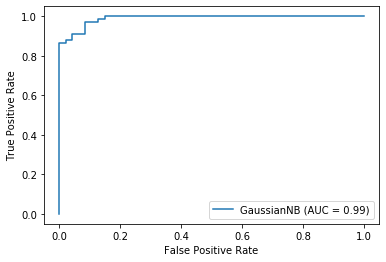

In [34]:
plot_roc_curve(model, X_test, y_test)


# Tree based methods (decision trees and random forests)

Decision trees are another popular class of ML algorithms. Once trained, a decision tree works something like the picture below: a sequence of questions are posed, at each step narrowing down the possible number of outcomes (predictions).

<img src="assets/dt_flowchart.jpg" style="width:40%"/>


The training process is concerned with identifying the optimal split: the one which is maximally informative. But how do we find it? We introduce the concept of purity. A (data)set of objects is considered pure if it contains only a single class, and impure if it is a mixture of classes. The more even the mix is, the less pure. If we find a way to compute "purity", all we need is to identify the split that increases the purity the most. As such we keep splitting subsets of subsets of the original data, all until we are left with completely pure "leaf nodes" (the terminal nodes) or once the tree is of particular depth. We often want to do an early stopping simply because of the danger of overfitting.


### Entropy
The way we do quantify purity is in terms of the information theoretical concept *entropy*.

<img src="assets/Decision_Tree_ex2.jpg" style="width:40%"/>

The entropy is maximimal when the data is maximally impure, and zero when the data is completely pure. 

<img src="assets/Entropy_plot.png" style="width:40%"/>

The entropy is again defined in terms of probability. In the binary case specifically 
$$ Entropy = -\sum_{i=1}^n {\mathrm{P}(x_i) \log \mathrm{P}(x_i)}$$

Now the problem has only become to perform an exhaustive search of splits through the features that will yield the largest decrease of entropy. This is known as the *information gain* (IG).

A variant of impurity measurement, called the *Gini index* has become more popular, but the general idea is the same.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=0)

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
model = DecisionTreeClassifier()

In [55]:
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [56]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80        53
           1       0.87      0.91      0.89        90

    accuracy                           0.86       143
   macro avg       0.85      0.84      0.85       143
weighted avg       0.86      0.86      0.86       143



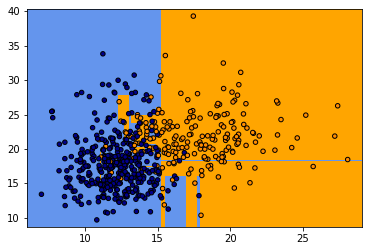

In [57]:
plot_decision_boundary(model, X, y)

A benefit of DTs is perfect transparency, making it easy to judge its inner workings (and derive feature importances):

In [ ]:
from sklearn import tree

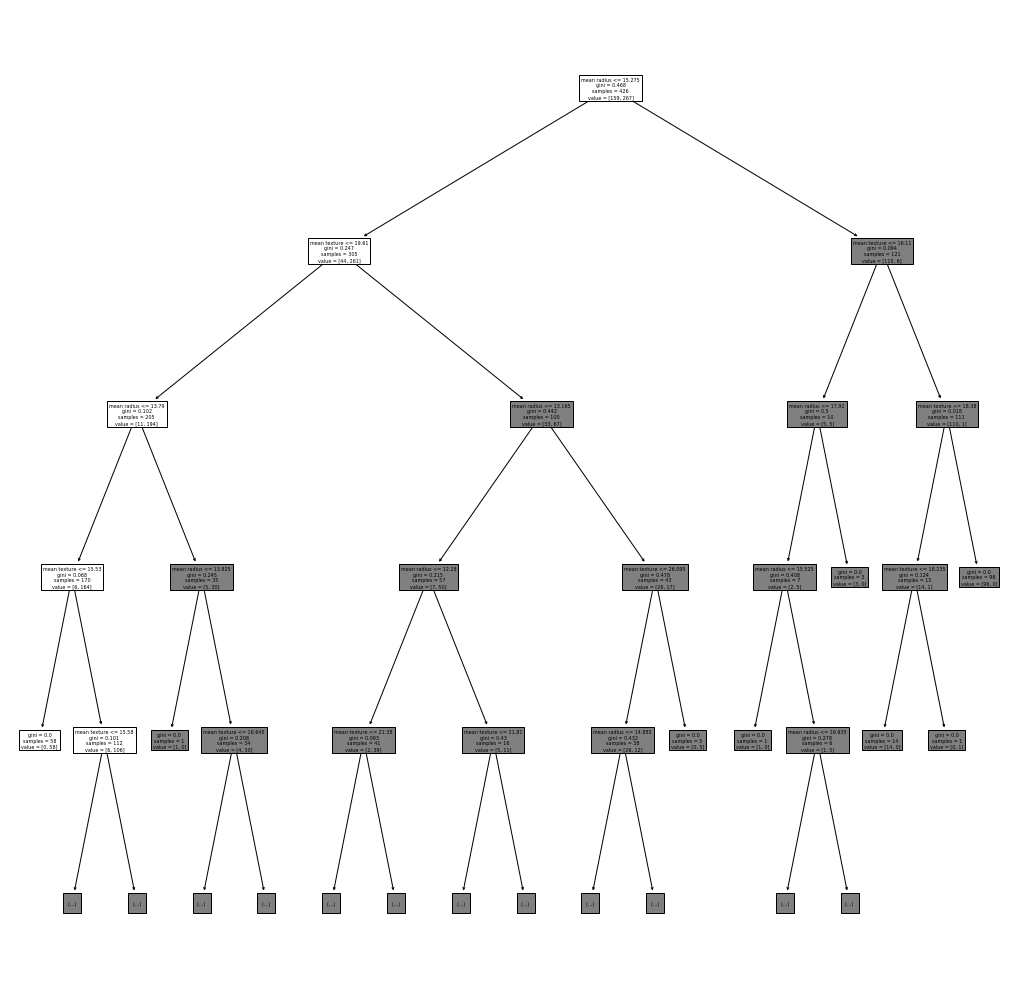

In [71]:
plt.figure(figsize=(18,18))
tree.plot_tree(model,feature_names=brca.feature_names, max_depth=4); plt.show()

# Random forest
### Improving DTs by adding more of them

A powerful concept in statistics is bootstrapping: making random resamplings of your dataset a large number of times, each time recomputing your test statistic. From this distribution you can gain a better estimate than the straight forward way. In a similar spirit, we can again subsample our data, but at each step train a new DT. Once we have this *ensemble* of DTs, we can make a prediction by letting each tree vote in a democratic process: the majority wins.

In [263]:
from sklearn.ensemble import RandomForestClassifier

In [264]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

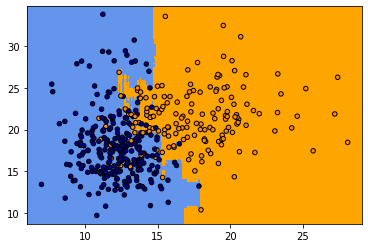

In [265]:
plot_decision_boundary(model, X_train, y_train)

In [267]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        53
           1       0.89      0.89      0.89        90

    accuracy                           0.86       143
   macro avg       0.85      0.85      0.85       143
weighted avg       0.86      0.86      0.86       143



### Bias-variance tradeoff
Tree-based methods have the versatility that they make zero assumption about the underlying data (unlike Naive Bayes for instance, which assumes statistical independence). They are thus regarded as having *low bias* and *high variance*. This is a common distinction, the **bias-variance tradeoff**, and it is difficult to optimize both simultaneously. There is no reason to dismiss any model a priori, each performs well in certain situations and fails in others. But in general *ensemble* methods like Random Forest is preferred over a single decision tree, which is very inconsistent.

One important drawback to random forests is obviously they take much more computer resources to train.

In [271]:
from sklearn.metrics import accuracy_score, f1_score

Run the cell below to illustrate difference in variability

Decision Tree 
accuracy variability: 0.02097191021682805 
f1 variability: 0.01749140004242865

Random Forest 
accuracy variability: 0.01638513918022375 
f1 variability: 0.01299587939106975


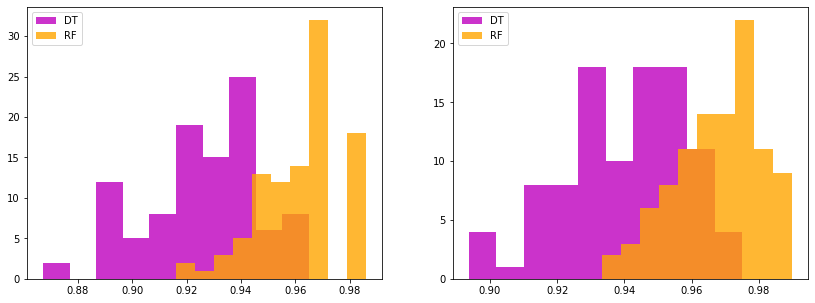

In [335]:
# illustrate the variability of DTs

def run(model):
    X_train, X_test, y_train, y_test = train_test_split(X, y) # random state gives different split each time
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    #print(f"accuracy: {acc}, \nf1 score: {f1}")
    
    return acc, f1



np.set_printoptions(precision=2)
fig, axs = plt.subplots(1, 2, figsize=(14,5))


N = 150 #number of repeats

# DT
model = DecisionTreeClassifier()
accs, f1s = [], []
for i in range(N):
    acc, f1 = run(model)
    accs.append(acc)
    f1s.append(f1)

print(f"Decision Tree \naccuracy variability: {np.std(accs)} \nf1 variability: {np.std(f1s)}")
print()

axs[0].hist(accs, alpha=.8, color='m', label='DT')
axs[1].hist(f1s, alpha=.8, color='m', label='DT')

# Random Forest
model = RandomForestClassifier()
accs, f1s = [], []
for i in range(N):
    acc, f1 = run(model)
    accs.append(acc)
    f1s.append(f1)    

print(f"Random Forest \naccuracy variability: {np.std(accs)} \nf1 variability: {np.std(f1s)}")

axs[0].hist(accs, alpha=.8, color='orange', label='RF')
axs[1].hist(f1s, alpha=.8, color='orange', label='RF')

axs[0].legend()
axs[1].legend()
plt.show()

As we see the RF model is less variable than the DT (and incidentally has a better performance).

### ROC curves 

### Optimizing hyperparameters through cross validation
[TODO]

## "Reading thoughts" from brain scans

The most common type of functional magnetic resonance imaging (fMRI) works by recording magnetic field fluctuations inside brains. Blood oxygenation levels is the factor being measured, and is indicative of regional brain activity. Thoughts and other neural processes yields different patterns of brain activity, and thus theory predicts we should be able to discriminate mental states from fMRI scans. This is known as **neural decoding**.

### The Haxby experiment
A pioneering experiment in this field was performed by Haxby et al. (2001), in which they scanned subjects under different visual stimuli: pictures of houses and pictures of human faces (among others). Here we will reproduce the experiment. The library `nilearn` has built in everything we need. 

In [110]:
from nilearn import datasets
from nilearn.plotting import show

We have to download the dataset.

In [111]:
haxby_dataset = datasets.fetch_haxby(fetch_stimuli=True) # only the stimulus, 
stimulus_info = haxby_dataset.stimuli # list of paths for images

In [112]:
# The various categories
stimulus_info.keys()

dict_keys(['bottles', 'cats', 'chairs', 'controls', 'faces', 'houses', 'scissors', 'shoes'])

We can look at the images viewed by the test subjects.

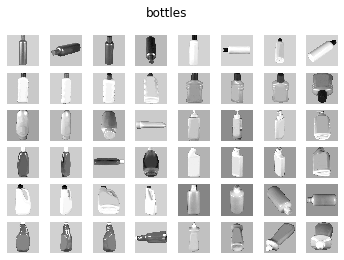

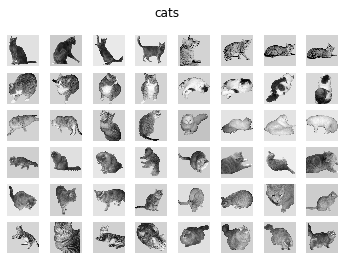

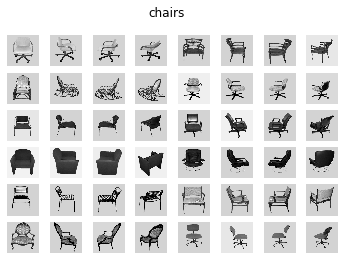

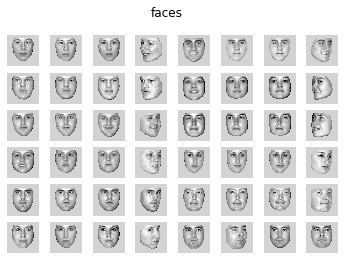

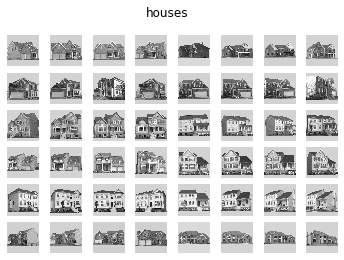

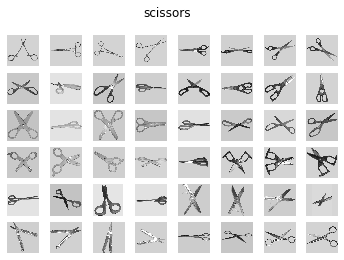

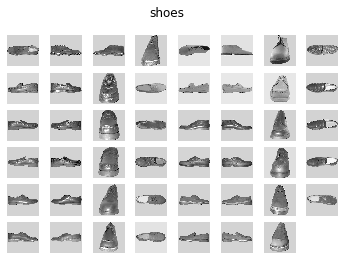

In [113]:
# plot the stimulus 
for stim_type in stimulus_info:
    # skip control images, there are too many
    if stim_type != 'controls':

        file_names = stimulus_info[stim_type]

        fig, axes = plt.subplots(6, 8)
        fig.suptitle(stim_type)

        for img_path, ax in zip(file_names, axes.ravel()):
            ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

        for ax in axes.ravel():
            ax.axis("off")

show()

In [114]:
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])

Mask nifti image (3D) is located at: C:\Users\Peder/nilearn_data\haxby2001\mask.nii.gz
Functional nifti image (4D) is located at: C:\Users\Peder/nilearn_data\haxby2001\subj2\bold.nii.gz


In [115]:
# First we load a volume. 
from nilearn import image
func_filename = haxby_dataset.func[0] # the first test subject
func_0 = image.load_img(func_filename).slicer[:,:,:,0] # the first volume in the 4D fMRI data

In the machine learning jargon, we consider each voxel (3D pixel) as a *feature*. The vast number of voxels in the image poses a challenge (curse of dimensionality), so we want to do some feature selection before training the classifier. But first: 
**Ex. xx: how many voxels are in the input volume?** 

In [116]:
#Your task is to find out how to access the dimensions. 
# Tip: write "func_0." and press tab to see the options.

# Your code here

In [117]:
# answer
print(f"The zyx-dimensions are {func_0.shape}")
np.prod(func_0.shape) # Total number of features

The zyx-dimensions are (40, 64, 64)


163840

We have to retrieve the labels for each volume (i.e. *what* was the subject looking at?). We have limited ourselves to only two states, so you will have to do some basic data manipulation of the labels. You should carefully read the code below to understand how the data is formatted to fit into the model (Scikit-learn accepts only labels on certain formats, as a one-dimensional numpy array or a pandas Series object).

**Tip:** print the intermediate dataframes to understand what each line of code achieves.

In [118]:
# Load target information as string and give a numerical identifier to each
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']

# Restrict the analysis to faces and places
condition_mask = behavioral['labels'].isin(['face', 'house']) # we will only consider two states
y = conditions[condition_mask]

# Confirm that we now have 2 conditions
print(y.unique())

# Record these as an array of sessions, with fields
# for condition (face or house) and run
session = behavioral[condition_mask].to_records(index=False)
print(session.dtype.names)

['face' 'house']
('labels', 'chunks')


So far we have defined the labels `y`. The next step is to defined the data `X` as a (**samples x features**) matrix. In `nilearn`, masker-objects will apply a mask and extract the data from the region and put into a numpy array, `X`. 

In [137]:
from nilearn.input_data import NiftiMasker

mask_filename = haxby_dataset.mask

# For decoding, standardizing is often very important
# note that we are also smoothing the data
masker = NiftiMasker(mask_img=mask_filename, smoothing_fwhm=4,
                     standardize=True, memory="nilearn_cache", memory_level=1)
func_filename = haxby_dataset.func[0] # the first test subject
X = masker.fit_transform(func_filename) # applying the mask
X = X[condition_mask] # selecting only the volumes in condition_mask, i.e. only houses and faces

Now X is on the form that we typically represent data (rows as samples and columns as features). **Ex.XX. a) How many samples do we have in X? b) Compare the shape of X and y**.

In [120]:
# answer: 216. Matrices are always represented in the order: (rows, columns).
# 216 samples, i.e. timepoints
print(X.shape)
print(y.shape)

(216, 39912)
(216,)


Now that the data has been prepared for machine learning, most of the work is behind us. In the next step we can select any classifier and put it to the task. We start with the linear support vector machine (SVM) (called SVC in `sklearn`), which is both effective and fast to train. Because we have roughly 40K features, we select only the most informative ones (this increases both training speed and accuracy). an F-test can help us do so, again available from `sklearn`.

In [135]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

# Define the dimension reduction to be used.
# Here we use a classical univariate feature selection based on F-test,
# namely Anova. When doing full-brain analysis, it is better to use
# SelectPercentile, keeping 1% of voxels
# (because it is independent of the resolution of the data).
from sklearn.feature_selection import SelectPercentile, f_classif
feature_selection = SelectPercentile(f_classif, percentile=1)

# We have our classifier (SVC), our feature selection (SelectPercentile),and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import make_pipeline
anova_svc = make_pipeline(feature_selection, svc)

### Cross validation

The low **n_samples:n_features** ratio incentivices us to use as many samples as possible for training, while minimizing the test size. We can get an unbiased evaluation of our approach with leave-one-out cross validation. The figure below describes the general process when doing model selection. Here we will deviate slightly by not holding out a final test set.

![title](assets/cross_val.jpg)

In [124]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneGroupOut cross-validation on the session group
# which corresponds to a leave-one-session-out
cv = LeaveOneGroupOut()

# Compute the prediction accuracy for the different folds (i.e. session)
cv_scores = cross_val_score(anova_svc, X, y, cv=cv, groups=session)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" %
      (classification_accuracy, 1. / len(y.unique())))

Classification accuracy: 0.7824 / Chance level: 0.500000


NB! on study design: because the data is time-continuous, it would be biased if you tried to predict a new time point sitting right in between two already known time points. Because the measurements were divided into *sessions*, we remove a whole session for validation, avoiding the problem of autocorrelation.

### Which brain area is responsible?

So MVPA allows for prediction of mental states from patterns in activity. Now we can ask a biologically interesting question: what part of the brain is responsible for this discrimination of faces and houses? How might you go about to answer such a question? It is surprisingly simple to begin to answer. We can look at the weights assigned by the model. It is not straight-forward to interpret the weights of a SVM, but the information held in `svc.coef_` can be used to weight the importance of the different features. We use the whole dataset 

In [142]:
anova_svc.fit(X, y)
#y_pred = anova_svc.predict(X)

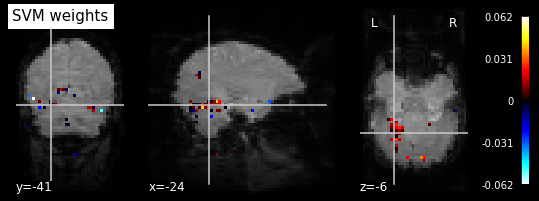

In [143]:
coef = svc.coef_ # the seperating hyperplane is defined by this vector
# reverse feature selection
coef = feature_selection.inverse_transform(coef) # expand to the full 40K voxels
# reverse masking
weight_img = masker.inverse_transform(coef) # Reshape the array of coefs back to 3D to match the MRI volume

# Use the mean image as a background to avoid relying on anatomical data
from nilearn import image
mean_img = image.mean_img(func_filename)

# Create the figure
from nilearn.plotting import plot_stat_map, show
plot_stat_map(weight_img, mean_img, title='SVM weights')

# Saving the results as a Nifti file may also be important
#weight_img.to_filename('haxby_face_vs_house.nii')

show()